# HOMEWORK 3: Pricing Barrier Options (Monte Carlo Method)
## Vitalii Rudko
## May, 2021

In [1]:
#Importing packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import yfinance as yf

In [18]:
#Importing data
sp500_df = yf.download('^GSPC', 
                      start = '2020-04-25', 
                      end = '2021-04-25', 
                      interval = "1d",
                      progress = False)
sp500_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-24,2812.639893,2842.709961,2791.760010,2836.739990,2836.739990,5374480000
2020-04-27,2854.649902,2887.719971,2852.889893,2878.479980,2878.479980,5194260000
2020-04-28,2909.959961,2921.149902,2860.709961,2863.389893,2863.389893,5672880000
2020-04-29,2918.459961,2954.860107,2912.159912,2939.510010,2939.510010,6620140000
2020-04-30,2930.909912,2930.909912,2892.469971,2912.429932,2912.429932,6523120000


In [488]:
#Calculating returns
returns = np.diff(np.log(np.array(sp500_df["Close"])))

#S0 - initial price of underlying asset (in points, one point worth $100)
S0 = np.array(sp500_df["Close"])[-1]

#K - strike price
K = 4000

#H - barrier
H = 4300

#r - risk free rate (OIS on Effective Funds Rate)
#Source: https://www.swapsandbonds.com/
r = 0.0013

#T - time to maturity
T = 1

#steps - number of steps per year in each simulation
steps = 253

#q -dividend yield
q = 0

#mu - mean (annual)
mu = np.exp(np.mean(returns) * 252) - 1

#vol - volatility (annual)
vol = np.std(returns) * steps**.5

#sim - number of simulations
sim = 10000

In [489]:
#Defining a function for the simulation of GBM paths
def GBM(sim, T, steps, mu, vol, S0, q):
    #Importing dependencies 
    from numpy.random import normal
    from math import exp
    
    #Calculating dt as (year/steps)
    dt = 1/steps
    
    #Calculating all steps
    steps = int(steps*T)
    
    #Creating a zero array and inserting the S0 row
    output = [[0]*sim for i in range(steps)]
    output = [[S0]*sim] + output
    
    #Filling the array with simulated values 
    for i in range(1, steps + 1):
        for j in range(sim):
            output[i][j] = output[i-1][j] * exp((mu - q - 0.5 * vol**.5) * dt + vol * dt**.5 * normal())
    
    #Returning the output        
    return output           

In [490]:
#Conducting the simulation
sim_prices = np.array(GBM(sim, T, steps, mu, vol, S0, q))

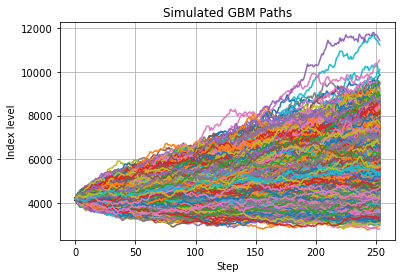

In [491]:
#Ploting results of simulation 
plt.plot(sim_prices);
plt.title("Simulated GBM Paths")
plt.xlabel("Step")
plt.ylabel("Index level")
plt.grid()

In [492]:
#Defining the function for pricing up-and-in call 
def MC_up_in_call(sim_prices, K, H, r, T):
    #Importing dependencies
    from numpy import array, mean
    from math import exp
    
    #Initializing an empty array 
    output = []
    
    #Transposing input array
    sim_prices = sim_prices.T
    
    #Finding the number of rows 
    nrow = sim_prices.shape[0]
    
    #Checking if S >= H
    for i in range(nrow):
            
        if sum(sim_prices[i] >= H) != 0:
            output.append(exp(-r*T) * max(sim_prices[i][-1] - K, 0))
        else:
            output.append(0)
    
    #Calculating the mean and returning the output
    return np.mean(output)

#Defining the function for pricing up-and-in call 
def MC_up_in_put(sim_prices, K, H, r, T):
    #Importing dependencies
    from numpy import array, mean
    from math import exp
    
    #Initializing an empty array 
    output = []
    
    #Transposing input array
    sim_prices = sim_prices.T
    
    #Finding the number of rows 
    nrow = sim_prices.shape[0]
    
    #Checking if S >= H
    for i in range(nrow):
            
        if sum(sim_prices[i] >= H) != 0:
            output.append(exp(-r*T) * max(K - sim_prices[i][-1], 0))
        else:
            output.append(0)
    
    #Calculating the mean and returning the output
    return np.mean(output)

#Defining the function for pricing up-and-out call 
def MC_up_out_call(sim_prices, K, H, r, T):
    #Importing dependencies
    from numpy import array, mean
    from math import exp
    
    #Initializing an empty array 
    output = []
    
    #Transposing input array
    sim_prices = sim_prices.T
    
    #Finding the shape
    nrow = sim_prices.shape[0]
    ncol = sim_prices.shape[1]
    
    #Checking if S >= H
    for i in range(nrow):
        for j in range(ncol):
            if sim_prices[i][j] >= H:
                output.append(np.exp(-r*j/252) * max(sim_prices[i][j] - K, 0))
                break
            else:
                if j == ncol-1:
                    output.append(np.exp(-r*j/252) * max(K - sim_prices[i][j], 0))
    
    #Calculating the mean and returning the output
    return np.mean(output)

#Defining the function for pricing up-and-out put 
def MC_up_out_put(sim_prices, K, H, r, T):
    #Importing dependencies
    from numpy import array, mean
    from math import exp
    
    #Initializing an empty array 
    output = []
    
    #Transposing input array
    sim_prices = sim_prices.T
    
    #Finding the shape
    nrow = sim_prices.shape[0]
    ncol = sim_prices.shape[1]
    
    #Checking if S >= H
    for i in range(nrow):
        for j in range(ncol):
            if sim_prices[i][j] >= H:
                output.append(np.exp(-r*j/252) * max(K - sim_prices[i][j], 0))
                break
            else:
                if j == ncol-1:
                    output.append(np.exp(-r*j/252) * max(K - sim_prices[i][j], 0))
    
    #Calculating the mean and returning the output
    return mean(output)

In [493]:
#Calculating the price for up-and-in call
round(MC_up_in_call(sim_prices, K, H, r, T) * 100, 2)

154366.27

In [494]:
#Calculating the price for up-and-in put
round(MC_up_in_put(sim_prices, K, H, r, T) * 100, 2)

791.32

In [495]:
#Calculating the price for up-and-out call
round(MC_up_out_call(sim_prices, K, H, r, T) * 100, 2)

32889.36

In [496]:
#Calculating the price for up-and-out put
round(MC_up_out_put(sim_prices, K, H, r, T) * 100, 2)

418.16